In [1]:
import jax
import jax.numpy as jnp
import haiku as nn
import haiku as hk
import optax as tx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

from jax.example_libraries import optimizers
from jax.example_libraries.optimizers import adamax as optimizer
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update('jax_disable_jit', True)
# import os
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.50'
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
SCALE = 1e-2
INIT_KEYS = jax.random.split(jax.random.PRNGKey(1), 8)
KEY = jax.random.PRNGKey(42)
TRAIN_NEW = True

BETA = 0.8
MAX_AGE = 2.
MIN_DP = 0.2
INTEREST = 0.5

R = (1 + INTEREST)
B = BETA
BR = B * R
OBJECTIVE_FN = lambda x, t: jax.lax.select((jnp.where(t == 1, size=1)[0] == 2)[0], 
                                           jnp.array([jnp.log(x), 
                                                      x, 
                                                      0., 
                                                      1.]), 
                                           jax.lax.select((jnp.where(t == 1, size=1)[0] == 1)[0], 
                                                          jnp.array([jnp.log((1 / (1 + B)) * x) + BETA * jnp.log(R * (1 - (1 / (1 + B))) * x), 
                                                                     (1 / (1 + B)) * x, 
                                                                     R * (1 - (1 / (1 + B))) * x, 
                                                                     1.]), 
                                                          jax.lax.select((jnp.where(t == 1, size=1)[0] == 0)[0],
                                                              jnp.array([jnp.log((1 / (1 + B + B**2)) * x) +\
                                                                         BETA * jnp.log((1 / (1 + B)) * R * (1 - (1 / (1 + B + B**2))) * x) +\
                                                                         BETA**2 * jnp.log(R * (B / (1 + B)) * R * (1 - (1 / (1 + B + B**2))) * x),
                                                                         ((1) / (1 + B + B**2)) * x,
                                                                         R * (1 - ((1) / (1 + B + B**2))) * x,
                                                                         1.]),
                                                              jnp.array([0., 0., 0., 1.]))))


HIDDEN_STATE_SIZE = 2
GRID_SIZE = 200
X = jnp.linspace(1e-5, 1, GRID_SIZE)
STATE_SPACE = jnp.concatenate((
    jnp.concatenate((X.reshape(-1, 1), jnp.ones((GRID_SIZE, 1))), axis=1),
    jnp.concatenate((X.reshape(-1, 1), jnp.zeros((GRID_SIZE, 1))), axis=1)),
axis=0)

In [3]:
class Attention_Layer(nn.Module):
    def __call__(self):
        return jnp.sum(jax.nn.softmax(nn.Linear(1)(self.ys)).reshape(-1, 1) * self.ys, axis=0)
    
    def __init__(self, ys, name=None):
        super().__init__(name=name)
        self.ys = ys


class Blue_GRU(nn.Module):
    def __call__(self, ys, carry):
        d0 = carry[:(2 * self.hidden_state_size)]
        u0 = carry[(2 * self.hidden_state_size):]
        attention_layer = Attention_Layer(ys)
        
        d1, u1 = nn.GRU(2 * self.hidden_state_size)(d0, jnp.concatenate((attention_layer(), u0)))
        u1 = u1[:(self.hidden_state_size)]
        return jnp.concatenate((d1, u1)), u1
    
    def __init__(self, state_size, name=None):
        super().__init__(name=name)
        self.hidden_state_size = state_size


def multihead_lift_scan(inputs, state_space):
    N = state_space.shape[0]
    input_layer = hk.Linear(HIDDEN_STATE_SIZE)(inputs)
    
    yellow_functions = [hk.GRU(HIDDEN_STATE_SIZE) for i in jnp.arange(N)]
    yellow_init_applies = jax.tree_map(lambda net: hk.transform(net), yellow_functions)
    yellow_inits = [i.init for i in yellow_init_applies]
    
    yellow_params = [hk.lift(yellow_inits[i], allow_reuse=True, name=f"yellow_lift")(hk.next_rng_key() if hk.running_init() else None, state_space[0], input_layer) for i in range(N)]
    yellow_storage = hk.data_structures.to_mutable_dict(yellow_params[0])
    yellow_keys = list(yellow_storage.keys())
    just_yellow_params = [next(iter(p.values())) for p in yellow_params]
    stacked_yellow_params = jax.tree_map(lambda *arrays: jnp.stack(arrays), *just_yellow_params)
    yellow_storage[yellow_keys[0]] = stacked_yellow_params    
    
    blue_functions = [Blue_GRU(HIDDEN_STATE_SIZE) for i in jnp.arange(N)]
    blue_init_applies = jax.tree_map(lambda net: hk.transform(net), blue_functions)
    blue_inits = [i.init for i in blue_init_applies]
    
    blue_init_carry = jnp.zeros(3 * HIDDEN_STATE_SIZE)
    init_ys = jnp.zeros((state_space.shape[0], HIDDEN_STATE_SIZE))
    
    blue_params = [hk.lift(blue_inits[i], allow_reuse=True, name=f"blue_lift")(hk.next_rng_key() if hk.running_init() else None, init_ys, blue_init_carry) for i in range(N)]
    just_blue_att_params = [list(x.values())[0] for x in blue_params]
    just_blue_gru_params = [list(x.values())[1] for x in blue_params]
    
    blue_storage = hk.data_structures.to_mutable_dict(blue_params[0])
    blue_outer_keys = list(blue_storage.keys())
    blue_inner_keys = [list(x.keys()) for x in blue_storage.values()]
    
    stacked_blue_att_params = jax.tree_map(lambda *arrays: jnp.stack(arrays), *just_blue_att_params)
    stacked_blue_gru_params = jax.tree_map(lambda *arrays: jnp.stack(arrays), *just_blue_gru_params)
    
    blue_storage[blue_outer_keys[0]] = stacked_blue_att_params
    blue_storage[blue_outer_keys[1]] = stacked_blue_gru_params
    
    def apply_fn(apply_fns, carry, scan):
        params, inputs = scan
        key = hk.next_rng_key()
        return apply_fns[0].apply(params, key, inputs, carry)

    hn, ys = hk.scan(jax.tree_util.Partial(apply_fn, yellow_init_applies), input_layer, (yellow_storage, state_space))
    dn, us = hk.scan(jax.tree_util.Partial(apply_fn, blue_init_applies), 
                     jnp.concatenate((hn, jnp.zeros(2 * HIDDEN_STATE_SIZE))), 
                     (blue_storage, jnp.repeat(ys[jnp.newaxis, ...], state_space.shape[0], axis=0)))

    us_flat = jnp.squeeze(hk.Linear(1)(us)) / 1e3
    t = jnp.where(inputs == 1., size=1)[0][0]
    X = state_space[:, 0]
    o = state_space[:, 1]

    cu = X * jax.nn.sigmoid(us_flat)
    c = hk.cond((t >= MAX_AGE), lambda _: X, lambda _: cu, 0.)

    o1 = jnp.minimum(jnp.int32(X - c >= MIN_DP) + o, 1.)

    vu = hk.Linear(state_space.shape[0])(jnp.concatenate((us_flat, o1)))
    v = hk.cond((t > MAX_AGE), lambda _: jnp.zeros(state_space.shape[0]), lambda _: vu, 0.)

    predictions = jnp.concatenate((v.reshape(-1, 1), c.reshape(-1, 1)), axis=1)

    return predictions


def net(inputs, state_space):
    lift = multihead_lift_scan(inputs, state_space)
    return lift


init, apply = hk.transform(net)
init_params = init(jax.random.PRNGKey(42), jnp.zeros(4), STATE_SPACE)
MODEL = lambda params, state_space, inputs: jax.jit(apply)(params, KEY, inputs, state_space)

In [4]:
total_params = 0
for param in init_params.values():
    for arr in param.values():
        total_params += arr.reshape(-1, 1).shape[0]
print(f'Total Parameters: {total_params}')

Total Parameters: 376813


In [5]:
@jax.jit
def increment_t(t):
    i = jnp.where(t == 1, size=1)[0]
    return t.at[i].set(0).at[i+1].set(1)


@jax.jit
def neural_network(params, model_state, inputs):
    preds = MODEL(params, model_state, inputs)
    mat = jnp.concatenate((model_state, preds), axis=1) # For a given t, we have a tensor of (X, o, v, c)
    # So we just need to add o1 and x1 columns to this tensor
    o1 = jnp.minimum(jnp.int32(mat[:, 0] - mat[:, 3] >= MIN_DP) + mat[:, 1], 1.)
    x1 = (1 + o1 * INTEREST) * (mat[:, 0] - mat[:, 3])
    preds = jnp.concatenate((mat[:, 2:], x1.reshape(-1, 1), o1.reshape(-1, 1)), axis=1)
    return preds


@jax.jit
def loss(params, model_state, t0):
    t1 = increment_t(t0)
    preds0 = neural_network(params, model_state, t0)
    predicted_state = preds0[:, 2:]
    preds1 = neural_network(params, predicted_state, t1)
    
    v0 = preds0[:, 0]
    c0 = preds0[:, 1]
    o0 = model_state[:, 1]
    v1 = preds1[:, 0]
    c1 = preds1[:, 1]
    
    vf = lambda model_state, t: neural_network(params, model_state, t)[:, 0]
    cf = lambda model_state, t: neural_network(params, model_state, t)[:, 1]
    
    max_index = STATE_SPACE.shape[0] - 1
    c0x = jax.vmap(lambda i: (c0[jnp.minimum(i + 1, max_index)] - c0[jnp.maximum(i - 1, 0)]) / (model_state[jnp.minimum(i + 1, max_index), 0] - model_state[jnp.maximum(i - 1, 0), 0]))(jnp.arange(STATE_SPACE.shape[0]))
    v0x = jax.vmap(lambda i: (v0[jnp.minimum(i + 1, max_index)] - v0[jnp.maximum(i - 1, 0)]) / (model_state[jnp.minimum(i + 1, max_index), 0] - model_state[jnp.maximum(i - 1, 0), 0]))(jnp.arange(STATE_SPACE.shape[0]))
    v1x = jax.vmap(lambda i: (v1[jnp.minimum(i + 1, max_index)] - v1[jnp.maximum(i - 1, 0)]) / (predicted_state[jnp.minimum(i + 1, max_index), 0] - predicted_state[jnp.maximum(i - 1, 0), 0]))(jnp.arange(STATE_SPACE.shape[0]))
    
#     c0x = jnp.diag(jax.jacfwd(cf)(model_state, t0)[..., 0])
#     v0x = jnp.diag(jax.jacfwd(vf)(model_state, t0)[..., 0])
#     v1x = jnp.diag(jax.jacfwd(vf)(preds0[:, 2:], t1)[..., 0])
    
    live_next = (jnp.where(t0 == 1, size=1)[0][0] < MAX_AGE)
    loss_euler = jax.lax.select(live_next, o0 * (c1 - BR * c0), jnp.zeros(STATE_SPACE.shape[0]))
    loss_bellman = ((jnp.log(c0) + BETA * v1) - v0)
    loss_foc = jax.lax.select(live_next, BR * v1x  * c0 - 1, jnp.zeros(STATE_SPACE.shape[0]))
    loss_envelope = (c0x - c0 * v0x)
    
    return jnp.concatenate((loss_euler.reshape(-1, 1), loss_bellman.reshape(-1, 1), loss_foc.reshape(-1, 1), loss_envelope.reshape(-1, 1)), axis=1)


@jax.jit
def batch_loss(params, model_state, batch, W):
    losses = (jax.vmap(loss, in_axes=(None, None, 0))(params, model_state, batch)).reshape(-1, 4)
    # losses = jnp.array([loss(params, model_state, x) for x in batch]).reshape(-1, 4)
    mean_losses = jnp.squeeze(jnp.mean(losses**2, axis=0))
    return jnp.sum(W * mean_losses), tuple((mean_losses[0], mean_losses[1], mean_losses[2], mean_losses[3]))

In [6]:
@jax.tree_util.Partial(jax.jit, static_argnums=(3,))
def step(params, model_state, opt_state, optimizer, batch, W):
    (loss, (loss_euler, loss_bellman, loss_foc, loss_envelope)), grad = jax.value_and_grad(batch_loss, has_aux=True)(params, model_state, batch, W)
    updates, opt_state = optimizer.update(grad, opt_state, params)
    params = tx.apply_updates(params, updates)
    loss_components = tuple((loss_euler, loss_bellman, loss_foc, loss_envelope))
    return params, opt_state, loss, loss_components


def training_loop(grid, params, model_state, opt_state, optimizer, W=jnp.ones(4), max_iter=1000):
    j = 0
    while j < max_iter:
        params, opt_state, loss, loss_components = step(params, model_state, opt_state, optimizer, grid, W)
        
        if j == 0:
            start_time = time.time()
        
        if j % 100 == 0:
            print(f'Iteration: {j}\tCurrent Loss: {loss:.2f}\tAverage samples/s: {((grid.shape[0] * j) / (time.time() - start_time)):.2f}\n'
                  f'Loss Euler: {loss_components[0]}\tLoss Bellman: {loss_components[1]}\tLoss FoC: {loss_components[2]}\tLoss Envelope: {loss_components[3]}')
        j += 1
        
    return params, opt_state, model_state

In [7]:
optimizer = tx.adam(learning_rate=1e-2)

init_model_state = STATE_SPACE
init_opt_state = optimizer.init(init_params)

if TRAIN_NEW:
    model_state = init_model_state
    params = init_params
    opt_state = init_opt_state
else:
    params, opt_state, model_state, MODEL = pickle.load(open('rnn.pkl', 'rb'))
    
W = 1e2 * jnp.array([1., 1., 1., 1.])
GRID = jnp.concatenate((jnp.eye(3), jnp.zeros(3).reshape(-1, 1)), axis=1) # 3 different ages

params, opt_state, model_state = training_loop(GRID, params, model_state, opt_state, optimizer, W=W, max_iter=20000)

Iteration: 0	Current Loss: 158115.31	Average samples/s: 0.00
Loss Euler: 0.004071736242622137	Loss Bellman: 3.8662590980529785	Loss FoC: 886.3727416992188	Loss Envelope: 690.9099731445312
Iteration: 100	Current Loss: 430.20	Average samples/s: 9.91
Loss Euler: 0.004073208663612604	Loss Bellman: 2.6336443424224854	Loss FoC: 0.8882070183753967	Loss Envelope: 0.776041567325592
Iteration: 200	Current Loss: 267.57	Average samples/s: 9.97
Loss Euler: 0.004073229152709246	Loss Bellman: 2.366631507873535	Loss FoC: 0.13876157999038696	Loss Envelope: 0.16618689894676208
Iteration: 300	Current Loss: 238.79	Average samples/s: 9.99
Loss Euler: 0.004073272459208965	Loss Bellman: 2.2044010162353516	Loss FoC: 0.07988055050373077	Loss Envelope: 0.09955287724733353
Iteration: 400	Current Loss: 226.96	Average samples/s: 10.00
Loss Euler: 0.004073376301676035	Loss Bellman: 2.098767042160034	Loss FoC: 0.07722128927707672	Loss Envelope: 0.08955707401037216
Iteration: 500	Current Loss: 251.70	Average samples/

Iteration: 4300	Current Loss: 12845.42	Average samples/s: 10.00
Loss Euler: 0.00408386392518878	Loss Bellman: 0.5945190787315369	Loss FoC: 75.95636749267578	Loss Envelope: 51.89923095703125
Iteration: 4400	Current Loss: 4703.74	Average samples/s: 9.99
Loss Euler: 0.0040840767323970795	Loss Bellman: 0.47444576025009155	Loss FoC: 27.759740829467773	Loss Envelope: 18.79913330078125
Iteration: 4500	Current Loss: 10360.06	Average samples/s: 9.99
Loss Euler: 0.004081070888787508	Loss Bellman: 0.6061175465583801	Loss FoC: 61.7188606262207	Loss Envelope: 41.27150344848633
Iteration: 4600	Current Loss: 18946.54	Average samples/s: 9.99
Loss Euler: 0.004081400111317635	Loss Bellman: 0.6189509034156799	Loss FoC: 112.57174682617188	Loss Envelope: 76.27063751220703
Iteration: 4700	Current Loss: 3288.29	Average samples/s: 9.99
Loss Euler: 0.0040828469209373	Loss Bellman: 0.4770493805408478	Loss FoC: 19.844913482666016	Loss Envelope: 12.556875228881836
Iteration: 4800	Current Loss: 5416.92	Average sam

Iteration: 8700	Current Loss: 5545.92	Average samples/s: 9.99
Loss Euler: 0.00407390296459198	Loss Bellman: 0.6485198736190796	Loss FoC: 34.460235595703125	Loss Envelope: 20.346385955810547
Iteration: 8800	Current Loss: 13207.06	Average samples/s: 9.99
Loss Euler: 0.004073971416801214	Loss Bellman: 0.6397664546966553	Loss FoC: 80.7239761352539	Loss Envelope: 50.70282745361328
Iteration: 8900	Current Loss: 3355.24	Average samples/s: 9.99
Loss Euler: 0.004074058495461941	Loss Bellman: 0.6244468092918396	Loss FoC: 19.3209285736084	Loss Envelope: 13.602948188781738
Iteration: 9000	Current Loss: 1924.30	Average samples/s: 9.99
Loss Euler: 0.004074113443493843	Loss Bellman: 0.6109114289283752	Loss FoC: 11.177825927734375	Loss Envelope: 7.450140953063965
Iteration: 9100	Current Loss: 3237.63	Average samples/s: 9.99
Loss Euler: 0.004074152559041977	Loss Bellman: 0.6037054657936096	Loss FoC: 18.772048950195312	Loss Envelope: 12.996463775634766
Iteration: 9200	Current Loss: 3728.94	Average sampl

Iteration: 13000	Current Loss: 1871.83	Average samples/s: 9.98
Loss Euler: 0.004075072705745697	Loss Bellman: 0.3381352722644806	Loss FoC: 10.955338478088379	Loss Envelope: 7.420793056488037
Iteration: 13100	Current Loss: 5735.21	Average samples/s: 9.98
Loss Euler: 0.004075065720826387	Loss Bellman: 0.3418194353580475	Loss FoC: 35.66613006591797	Loss Envelope: 21.340059280395508
Iteration: 13200	Current Loss: 8428.80	Average samples/s: 9.98
Loss Euler: 0.004075032193213701	Loss Bellman: 0.3355987071990967	Loss FoC: 49.137107849121094	Loss Envelope: 34.81122970581055
Iteration: 13300	Current Loss: 6800.48	Average samples/s: 9.98
Loss Euler: 0.004075023345649242	Loss Bellman: 0.32925844192504883	Loss FoC: 41.44386291503906	Loss Envelope: 26.227598190307617
Iteration: 13400	Current Loss: 6883.51	Average samples/s: 9.98
Loss Euler: 0.004074976313859224	Loss Bellman: 0.3276228904724121	Loss FoC: 42.08919143676758	Loss Envelope: 26.4141845703125
Iteration: 13500	Current Loss: 846.75	Average 

Iteration: 17300	Current Loss: 18194.06	Average samples/s: 9.97
Loss Euler: 0.0040737660601735115	Loss Bellman: 0.20820562541484833	Loss FoC: 106.5013198852539	Loss Envelope: 75.22699737548828
Iteration: 17400	Current Loss: 10955.06	Average samples/s: 9.97
Loss Euler: 0.004073600750416517	Loss Bellman: 0.21157830953598022	Loss FoC: 67.42755126953125	Loss Envelope: 41.90740203857422
Iteration: 17500	Current Loss: 7228.15	Average samples/s: 9.97
Loss Euler: 0.0040739066898822784	Loss Bellman: 0.2125125229358673	Loss FoC: 43.25829315185547	Loss Envelope: 28.80657958984375
Iteration: 17600	Current Loss: 3970.06	Average samples/s: 9.97
Loss Euler: 0.004074103198945522	Loss Bellman: 0.22797374427318573	Loss FoC: 23.28736114501953	Loss Envelope: 16.181163787841797
Iteration: 17700	Current Loss: 1123.19	Average samples/s: 9.97
Loss Euler: 0.004073662683367729	Loss Bellman: 0.20017695426940918	Loss FoC: 6.701723575592041	Loss Envelope: 4.325909614562988
Iteration: 17800	Current Loss: 8085.46	Av

In [8]:
batch_loss(params, STATE_SPACE, GRID, jnp.ones(4))

(DeviceArray(74.77809, dtype=float32),
 (DeviceArray(0.00407314, dtype=float32),
  DeviceArray(0.17511822, dtype=float32),
  DeviceArray(44.199017, dtype=float32),
  DeviceArray(30.399883, dtype=float32)))

In [9]:
out0 = neural_network(params, model_state, GRID[0])
out1 = neural_network(params, model_state, GRID[1])
out2 = neural_network(params, model_state, GRID[2])

df = pd.DataFrame(jnp.concatenate((model_state, out0, out1, out2), axis=1),
                  columns=['X', 'o0', 
                           'v00', 'c00', 'x10', 'o10',
                           'v01', 'c01', 'x11', 'o11',
                           'v02', 'c02', 'x12', 'o12']).astype(np.float32)
df_owner = df[:GRID_SIZE].set_index('X')
df_renter = df[GRID_SIZE:].set_index('X')

df_owner.columns = [f'owner_{x}' for x in df_owner.columns]
df_renter.columns = [f'renter_{x}' for x in df_renter.columns]

t0 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([1, 0, 0, 0]))
t1 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0, 1, 0, 0]))
t2 = jax.vmap(OBJECTIVE_FN, in_axes=(0, None))(X, jnp.array([0, 0, 1, 0]))
df_true = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), t0, t1, t2), axis=1),
                       columns=['X', 
                                'v00', 'c00', 'x10', 'o10',
                                'v01', 'c01', 'x11', 'o11',
                                'v02', 'c02', 'x12', 'o12']).astype(np.float32).set_index('X')

df_true.columns = [f'true_{x}' for x in df_true.columns]

<AxesSubplot:xlabel='X'>

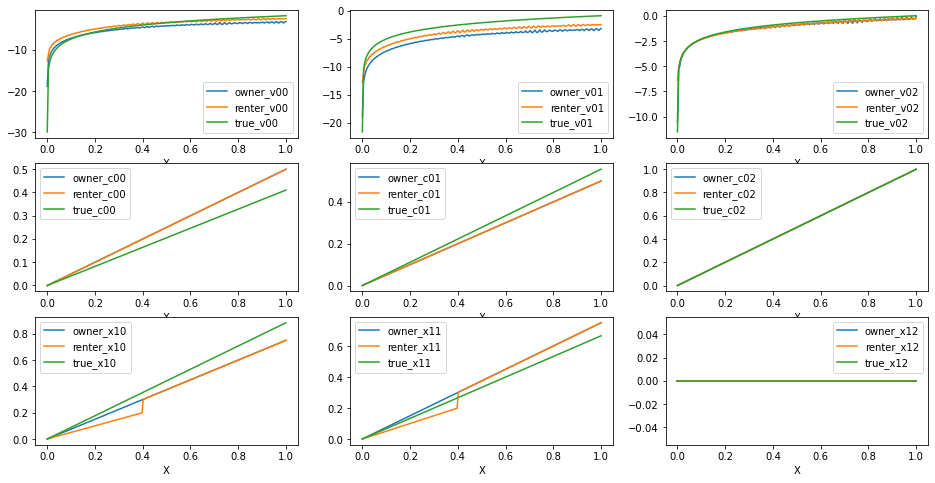

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(16, 8))

df_owner.plot(y='owner_v00', ax=axes.flatten()[0])
df_renter.plot(y='renter_v00', ax=axes.flatten()[0])
df_true.plot(y='true_v00', ax=axes.flatten()[0])
df_owner.plot(y='owner_v01', ax=axes.flatten()[1])
df_renter.plot(y='renter_v01', ax=axes.flatten()[1])
df_true.plot(y='true_v01', ax=axes.flatten()[1])
df_owner.plot(y='owner_v02', ax=axes.flatten()[2])
df_renter.plot(y='renter_v02', ax=axes.flatten()[2])
df_true.plot(y='true_v02', ax=axes.flatten()[2])

df_owner.plot(y='owner_c00', ax=axes.flatten()[3])
df_renter.plot(y='renter_c00', ax=axes.flatten()[3])
df_true.plot(y='true_c00', ax=axes.flatten()[3])
df_owner.plot(y='owner_c01', ax=axes.flatten()[4])
df_renter.plot(y='renter_c01', ax=axes.flatten()[4])
df_true.plot(y='true_c01', ax=axes.flatten()[4])
df_owner.plot(y='owner_c02', ax=axes.flatten()[5])
df_renter.plot(y='renter_c02', ax=axes.flatten()[5])
df_true.plot(y='true_c02', ax=axes.flatten()[5])

df_owner.plot(y='owner_x10', ax=axes.flatten()[6])
df_renter.plot(y='renter_x10', ax=axes.flatten()[6])
df_true.plot(y='true_x10', ax=axes.flatten()[6])
df_owner.plot(y='owner_x11', ax=axes.flatten()[7])
df_renter.plot(y='renter_x11', ax=axes.flatten()[7])
df_true.plot(y='true_x11', ax=axes.flatten()[7])
df_owner.plot(y='owner_x12', ax=axes.flatten()[8])
df_renter.plot(y='renter_x12', ax=axes.flatten()[8])
df_true.plot(y='true_x12', ax=axes.flatten()[8])

In [11]:
pickle.dump(tuple((params, opt_state, model_state, model)), open('rnn.pkl', 'wb'))

NameError: name 'model' is not defined